In [1]:
!pip install pandasql
!pip install statsmodels
!pip install matplotlib

In [2]:
import pandasql as ps
import pandas as pd
import numpy as np
import os
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movielens-20m-dataset/movie.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/rating.csv


In [4]:
genome_scores= pd.read_csv("/kaggle/input/movielens-20m-dataset/genome_scores.csv")
genome_tags= pd.read_csv("/kaggle/input/movielens-20m-dataset/genome_tags.csv")
movies= pd.read_csv("/kaggle/input/movielens-20m-dataset/movie.csv")
ratings= pd.read_csv("/kaggle/input/movielens-20m-dataset/rating.csv")
tag=pd.read_csv("/kaggle/input/movielens-20m-dataset/tag.csv")


In [5]:
movies["title"]=movies.title.str.strip()
movies["Title"]=movies.title.str[:-7]
movies["Year"]=movies.title.str[-5:-1]
movies.drop(columns=['title'],inplace=True)
#movies.genres.str.split('|',expand=True)
movies.head()

,movieId,genres,Title,Year
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Adventure|Children|Fantasy,Jumanji,1995
2,3,Comedy|Romance,Grumpier Old Men,1995
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Comedy,Father of the Bride Part II,1995


<table>
    <tr>
        <td style="font-size:24px; align=center; font-weight: bold" >Cleaning Movie Tags - Gathering most relevant tags with high predictive power</td>
    </tr>
</table>
    


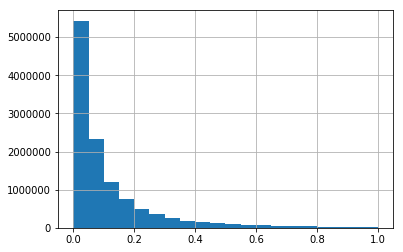

In [6]:
genome_scores.relevance.hist(bins=20)

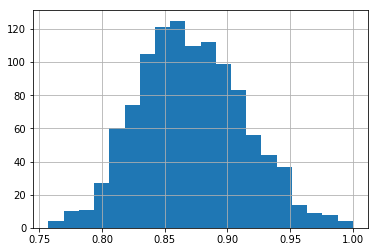

In [7]:
genome_scores.loc[genome_scores.relevance>0.75,:].groupby('tagId').relevance.agg('mean').hist(bins=20)

Most of the movies have a low relevance score. To determine the relevance threshold, we use the normal distribution. Since most statistical tests for normalcy are not suited for a large number of samples, we determine normaly by observing the distribuition curve. By trial and error we see that the bell curve is obtained when we set the threshold at 75%.

In [8]:
print("Portion of scores with relevance >=75% =",round(genome_scores.loc[genome_scores.relevance>=0.75].shape[0]/genome_scores.shape[0],2))
print(len(genome_scores.loc[genome_scores.relevance>0.75,:].tagId.unique()),"of",len(genome_scores.tagId.unique()),"tags have >75% of relevance atlease once")

Portion of scores with relevance >=75% = 0.01
1113 of 1128 tags have >75% of relevance atlease once


By taking relevance >75% we only focus on the most relevant tags while also getting rid of 99% of irrelevant scores

In [9]:
print("Distinct Tags: ",genome_scores.loc[genome_scores.relevance>0.75,:].tagId.nunique(),
      "/",genome_scores.tagId.nunique(),
      "\t\tMovies with atleast 1 tag > 75% relevance: ",genome_scores.loc[genome_scores.relevance>0.75,:].movieId.nunique(),
      "/",genome_scores.movieId.nunique())

Distinct Tags:  1113 / 1128 		Movies with atleast 1 tag > 75% relevance:  10280 / 10381


In [10]:
min_relevance =0.75
mapping = genome_scores.loc[genome_scores.relevance>min_relevance,:].groupby('tagId').movieId.nunique()#.astype('Int64')

genome_tags['Movies_With_High_Relevance'] = genome_tags['tagId'].map(mapping)

genome_tags['Avg_Relevance'] = genome_tags['tagId'].map(genome_scores.groupby('tagId').relevance.agg('mean'))

genome_tags['Avg_Relevance_Filtered'] = genome_tags['tagId'].map(genome_scores.loc[genome_scores.relevance>min_relevance,:].groupby('tagId').relevance.agg('mean'))


In [11]:
print("Most powerful predictor tags")
genome_tags.sort_values(['Movies_With_High_Relevance'],ascending=False)[:10].reset_index(drop=True)

Most powerful predictor tags


,tagId,tag,Movies_With_High_Relevance,Avg_Relevance,Avg_Relevance_Filtered
0,742,original,4237.0,0.730527,0.817262
1,230,comedy,1220.0,0.250628,0.888354
2,270,criterion,1155.0,0.388207,0.881498
3,646,mentor,1087.0,0.530233,0.833597
4,19,action,999.0,0.265466,0.904246
5,323,drama,928.0,0.361095,0.845060
6,846,relationships,889.0,0.282563,0.868493
7,972,storytelling,868.0,0.448479,0.836237
8,107,based on a book,839.0,0.273905,0.894765
9,465,great acting,826.0,0.345783,0.846185


In [12]:
print("Least Powerful Predictor Tags")
genome_tags.sort_values(['Movies_With_High_Relevance'],ascending=False)[-20:-10]

Least Powerful Predictor Tags


,tagId,tag,Movies_With_High_Relevance,Avg_Relevance,Avg_Relevance_Filtered
1041,1042,travel,1.0,0.047756,0.76650
170,171,bullshit history,1.0,0.063721,0.79175
708,709,no plot,1.0,0.113762,0.80900
761,762,over the top,1.0,0.062091,0.90750
199,200,chicago,1.0,0.026280,0.87350
37,38,airplane,NaN,0.019181,NaN
102,103,bad sequel,NaN,0.016774,NaN
154,155,boring,NaN,0.127249,NaN
162,163,brilliant,NaN,0.030055,NaN
255,256,corny,NaN,0.064105,NaN


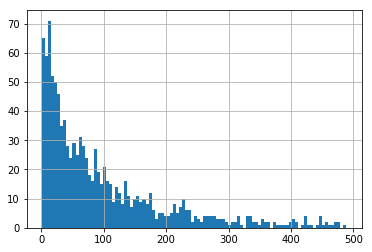

In [13]:
genome_tags.loc[genome_tags.Movies_With_High_Relevance<500].Movies_With_High_Relevance.reset_index(drop=True).hist(bins=100)

In [14]:
genome_tags.loc[genome_tags.Movies_With_High_Relevance>100].shape[0]

401

To determine the tags to use as features for our recommendations systems, we are seeing how many movies are the tags highly relevant to.
Given that we have 10381 movies, I choose to take tags that are relavant to atleast 100 movies.

Note:need to use box plot to identify outliers

**Top 5 popular tags of each year - for movies > 4.5 rating**


<table>
    <tr>
        <td style="font-size:24px; align=center; font-weight: bold" >Cleaning Movie List - Preparing Feature Set for recommendable movies</td>
    </tr>
</table>
    


In [15]:
ud_movie_ratings=pd.DataFrame(ratings.groupby('movieId').rating.agg('mean').reset_index())
ud_movie_ratings_count=pd.DataFrame(ratings.groupby('movieId').rating.agg('count').reset_index())
ud_movie_ratings_count.columns=["movieId","num_of_ratings"]
print(ud_movie_ratings.head())
print(ud_movie_ratings_count.head())

   movieId    rating
0        1  3.921240
1        2  3.211977
2        3  3.151040
3        4  2.861393
4        5  3.064592
   movieId  num_of_ratings
0        1           49695
1        2           22243
2        3           12735
3        4            2756
4        5           12161


In [16]:
result = pd.merge(movies, 
                  ud_movie_ratings,
                  left_on='movieId',
                  right_on='movieId',
                  how='left')
result = pd.merge(result, 
                  ud_movie_ratings_count,
                  left_on='movieId',
                  right_on='movieId',
                  how='left')
result=result.loc[result.Year.str.isnumeric(),:]
result["Year"]=result.Year.astype(int)

Being a recommendation system we want to focus only on movies that are liked by the people who have watched it. So we will restrict are training data to movies with above average rating. So I will use 3.5 which is a personal estimate.

For future work we can experiment with more data.

In [17]:
result =result.loc[((result.Year>1980)&(result.rating>=3.5))]
print("Number of movies that fit this criteria are:",result.shape[0])
result.head()

Number of movies that fit this criteria are: 6115


,movieId,genres,Title,Year,rating,num_of_ratings
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,3.921240,49695.0
5,6,Action|Crime|Thriller,Heat,1995,3.834930,23899.0
10,11,Comedy|Drama|Romance,"American President, The",1995,3.667713,18162.0
15,16,Crime|Drama,Casino,1995,3.787455,17394.0
16,17,Drama|Romance,Sense and Sensibility,1995,3.968573,20667.0


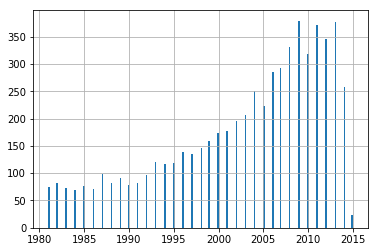

In [18]:
result.Year.sort_values().hist(bins=200)

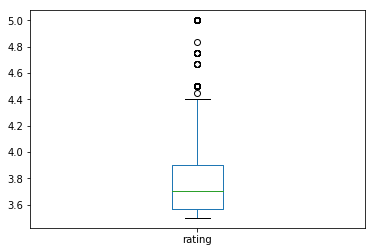

In [19]:
result.rating.plot.box()

Many movies have a rating of 5 which seems odd. So we should look at the number of ratings that contributed to this.

In [20]:
result.num_of_ratings.value_counts()

1.0        1127
2.0         487
3.0         295
4.0         217
5.0         150
           ... 
2292.0        1
12267.0       1
1065.0        1
817.0         1
2580.0        1
Name: num_of_ratings, Length: 1764, dtype: int64

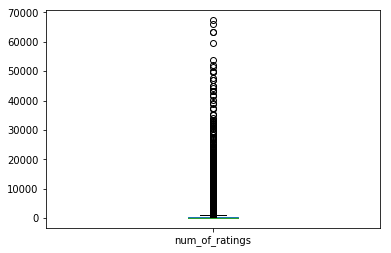

In [21]:
result.num_of_ratings.plot.box()

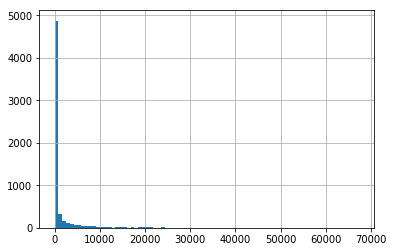

In [22]:
result.num_of_ratings.hist(bins=80)

We see that, a lot of the movies have very few ratings. These are outliers and will make our features set sparse. So we will need to estimate a good threshold for the minimum number of ratings we need. 
The above box plot or histograms do not help us gain a better sense of the data as we would have hoped. So we need to try other approaches.

In [23]:
print("Analysis of Number of Ratings for movies",
      "\n80th Quantile:\t",result.num_of_ratings.quantile(0.75),
      "\nMedian:\t\t",result.num_of_ratings.median(),
      "\nMean:\t\t",result.num_of_ratings.mean(),
      "\n\nFollowing Trossets rule of thumb for a good number of observations", 
      "\n25th Quantile:\t",result.loc[((result.num_of_ratings>32)),:].num_of_ratings.quantile(0.25),
      "\n75th Quantile:\t",result.loc[((result.num_of_ratings>32)),:].num_of_ratings.quantile(0.75),
      "\nMedian:\t\t",result.loc[((result.num_of_ratings>32)),:].num_of_ratings.median(),
      "\nMean:\t\t",result.loc[((result.num_of_ratings>32)),:].num_of_ratings.mean())

Analysis of Number of Ratings for movies 
80th Quantile:	 460.0 
Median:		 20.0 
Mean:		 1474.9355682747344 

Following Trossets rule of thumb for a good number of observations 
25th Quantile:	 160.0 
75th Quantile:	 2646.0 
Median:		 558.0 
Mean:		 3124.5022561610554


In [24]:
result=result.loc[((result.num_of_ratings>32))]

In [25]:
result.num_of_ratings.value_counts().head()

34.0    15
36.0    15
35.0    15
40.0    14
38.0    14
Name: num_of_ratings, dtype: int64

In [26]:
print("Total number of movies that will comprise are feature set are:",result.shape[0])

Total number of movies that will comprise are feature set are: 2881


# Building Recommendation System

In [27]:
ud_genome_tags=genome_tags.loc[genome_tags.Movies_With_High_Relevance>100]
ud_movie_fs=result

In [28]:
ud_movie_fs.head()

,movieId,genres,Title,Year,rating,num_of_ratings
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,3.921240,49695.0
5,6,Action|Crime|Thriller,Heat,1995,3.834930,23899.0
10,11,Comedy|Drama|Romance,"American President, The",1995,3.667713,18162.0
15,16,Crime|Drama,Casino,1995,3.787455,17394.0
16,17,Drama|Romance,Sense and Sensibility,1995,3.968573,20667.0


In [29]:
ud_movie_tags_relevance = pd.merge(genome_scores, 
                  ud_genome_tags,
                  left_on='tagId',
                  right_on='tagId',
                  how='inner')
ud_movie_tags_relevance=ud_movie_tags_relevance.loc[:,['movieId','tagId','relevance','tag']]
print("Number of records including high relevance tags:", ud_movie_tags_relevance.shape[0])
ud_movie_tags_relevance = pd.merge(ud_movie_tags_relevance, 
                  ud_movie_fs,
                  left_on='movieId',
                  right_on='movieId',
                  how='inner')
ud_movie_tags_relevance=ud_movie_tags_relevance.loc[:,['movieId','tagId','relevance','tag']]
print("Number of records including tags for movie subset:",ud_movie_tags_relevance.shape[0])
ud_movie_tags_relevance.sort_values(by=['movieId','relevance'],ascending=[False,False]).head(20)

Number of records including high relevance tags: 4162781
Number of records including tags for movie subset: 1043803


,movieId,tagId,relevance,tag
1043473,127098,230,0.90175,comedy
1043663,127098,742,0.82525,original
1043649,127098,691,0.79375,narrated
1043499,127098,289,0.74125,dark humor
1043510,127098,323,0.72675,drama
1043573,127098,468,0.71725,great ending
1043549,127098,417,0.67025,funny
1043782,127098,1071,0.66050,very funny
1043637,127098,646,0.65175,mentor
1043587,127098,505,0.63125,hilarious


In [30]:
print("\t\t".join(genome_scores.columns))
print("\t\t".join(genome_tags.columns))
print("\t\t".join(movies.columns))
print("\t\t".join(ratings.columns))
print("\t\t".join(tag.columns))

movieId		tagId		relevance
tagId		tag		Movies_With_High_Relevance		Avg_Relevance		Avg_Relevance_Filtered
movieId		genres		Title		Year
userId		movieId		rating		timestamp
userId		movieId		tag		timestamp


In [31]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


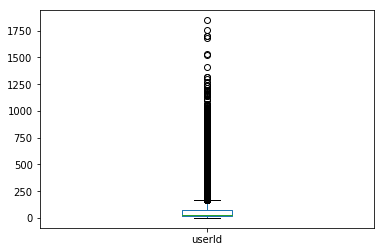

In [32]:
ud_ratings=ratings.loc[ratings.movieId.isin(ud_movie_fs.movieId) ]
ud_ratings.userId.value_counts().plot.box()

It seems odd that there are users who have seen so many movies. Ideally they should be investigated for authenticity. But with value for effort in mind, I choose to drop these users for the time being and do more analysis in the future.

In [33]:
ud_ratings.userId.value_counts().quantile(0.95)

230.0

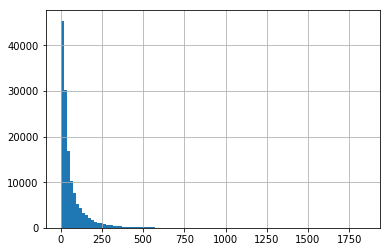

In [34]:
ud_ratings.userId.value_counts().hist(bins=100)

In [35]:
ss=pd.DataFrame(ud_ratings.userId.value_counts()).reset_index()
ss.columns=['userId','Counts']
ss=ss.loc[((ss.Counts<=250)&(ss.Counts>=3))]
ud_ratings=ud_ratings.loc[ud_ratings.userId.isin(ss.userId)]
print("Number of ratings after trimming out liers:",ud_ratings.shape[0])

Number of ratings after trimming out liers: 6778787


In [36]:
ud_user_movie_tags_rating = pd.merge(ud_ratings, 
                  ud_movie_tags_relevance,
                  left_on='movieId',
                  right_on='movieId',
                  how='inner')
#ud_movie_tags_relevance=ud_movie_tags_relevance.loc[:,['movieId','tagId','relevance','tag']]
print(ud_user_movie_tags_rating.shape)
ud_user_movie_tags_rating.head()

MemoryError: 